# Neutral Networks

Purpose of this notebook is to examin how accurate neutral networks are on this data set.

In [1]:
from keras.callbacks import History
from keras.layers import (
    Activation,
    Conv1D,
    Dense,
    Dropout,
    Flatten,
    MaxPooling1D,
)
from keras.models import Sequential
from keras.optimizers import (
    SGD,
    RMSprop,
)

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB

/home/kris/PycharmProjects/SUS/lab1/venv/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# To train on vectors made of two decks 
X_train = pd.read_csv('X_train.csv', index_col=0)
y_train = pd.read_csv('y_train.csv', index_col=0)

In [2]:
decks = pd.read_csv('decks.csv', index_col=0)
# All probabilities are already in decks.csv
# prob = pd.read_csv('prob.csv', index_col=0)

## Data visualization: distribution of vectors representing decks

In [5]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, verbose=1, perplexity=25, n_iter=1000)
tsne_results = tsne.fit_transform(decks.iloc[:, 0:-5])

[t-SNE] Computing 76 nearest neighbors...
[t-SNE] Indexed 400 samples in 0.007s...
[t-SNE] Computed neighbors for 400 samples in 0.121s...
[t-SNE] Computed conditional probabilities for sample 400 / 400
[t-SNE] Mean sigma: 2.705503
[t-SNE] KL divergence after 250 iterations with early exaggeration: 48.960487
[t-SNE] Error after 1000 iterations: 0.144068


/home/kris/PycharmProjects/SUS/lab1/venv/lib/python3.5/site-packages/ggplot/utils.py:81: FutureWarning: pandas.tslib is deprecated and will be removed in a future version.
You can access Timestamp as pandas.Timestamp
  pd.tslib.Timestamp,
/home/kris/PycharmProjects/SUS/lab1/venv/lib/python3.5/site-packages/ggplot/stats/smoothers.py:4: FutureWarning: The pandas.lib module is deprecated and will be removed in a future version. These are private functions and can be accessed from pandas._libs.lib instead
  from pandas.lib import Timestamp
/home/kris/PycharmProjects/SUS/lab1/venv/lib/python3.5/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


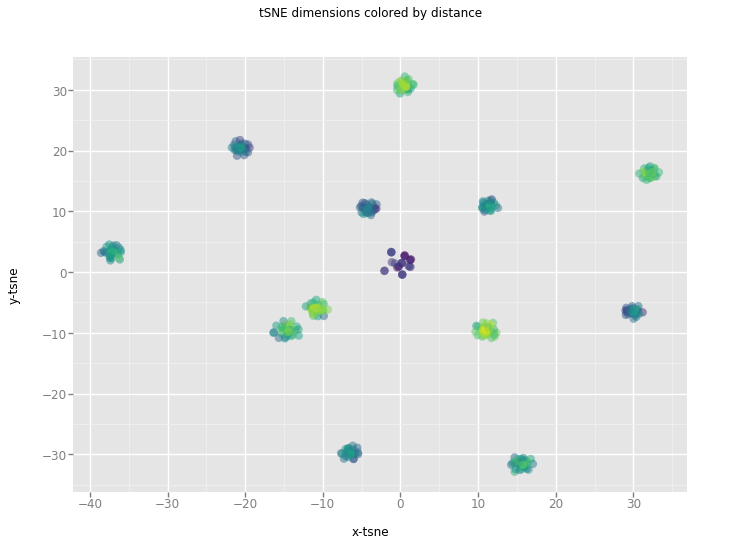

<ggplot: (8742412514217)>

In [6]:
%matplotlib inline
from ggplot import *

df_tsne = decks.copy()
df_tsne['x-tsne'] = tsne_results[:, 0]
df_tsne['y-tsne'] = tsne_results[:, 1]

chart = ggplot(df_tsne, aes(x='x-tsne', y='y-tsne')) \
        + geom_point(aes(colour='prob'), size=70, alpha=0.5) \
        + ggtitle("tSNE dimensions colored by distance")
chart

### Conclustion:

There are few types of decks in data set. Decks within one group/cluster are very similar to each other. On the other hand clusters are very different from one enother.

In this visualization colors of dots represent estimated win rate of deck. Important observation is that decks withing one cluster have similar colors (their win rates are similar).

## Data preprocessing

In [4]:
def add_bot_dummies(old_data_set):
    """Returns new data set with 4 times more rows and dummies for four bots."""
    # Data set should not contain probabilities
    data_set = np.array(old_data_set, dtype=np.int)
    
    nrows = data_set.shape[0]
    
    data_set = np.append(data_set, data_set, axis=0)
    data_set = np.append(data_set, data_set, axis=0)
    
    bots = np.zeros((1600, 4), dtype=np.int)
    bots[0:nrows, 0] = 1
    bots[nrows:2*nrows, 1] = 1
    bots[2*nrows:3*nrows, 2] = 1
    bots[3*nrows:4*nrows, 3] = 1
    
    data_set = np.append(data_set, bots, axis=1)
    
    return data_set

In [4]:
X_train = add_bot_dummies(decks.iloc[:, 0:-5].copy())

In [5]:
def get_bots_prob(bots_prob):
    """"Given array of probabilities for four bots returns 2D array with 4 times more rows and 4 times less columns"""
    bot_1 = np.array(bots_prob.iloc[:, 0], dtype=np.float)
    bot_2 = np.array(bots_prob.iloc[:, 1], dtype=np.float)
    bot_3 = np.array(bots_prob.iloc[:, 2], dtype=np.float)
    bot_4 = np.array(bots_prob.iloc[:, 3], dtype=np.float)
    
    bots = np.append(bot_1, bot_2, axis=0)
    bots = np.append(bots, bot_3, axis=0)
    bots = np.append(bots, bot_4, axis=0)
    bots = np.expand_dims(bots, axis=1)
    
    return bots

In [6]:
y_train = get_bots_prob(decks.iloc[:, -4:].copy())

In [6]:
def shuffle_and_expand_dims(X_train, y_train):
    
    if X_train.shape[0] != y_train.shape[0]:
        print("Wrong input")
        print("Number of rows in X: " + str(X_train.shape[0]))
        print("Number of rows in y: " + str(y_train.shape[0]))
    
    temp = np.append(X_train, y_train, axis=1)
    np.random.shuffle(temp)
    X_train = temp[:, 0:-1]
    y_train = temp[:, -1]
    
    # Keras sequential needs input to have 3D and clases (and predictions) to have 2D
    X_train = np.expand_dims(X_train, axis=2)
    y_train = np.expand_dims(y_train, axis=1)
    
    return X_train, y_train

In [8]:
X_train, y_train = shuffle_and_expand_dims(X_train, y_train)

In [10]:
print(X_train.shape)
print(y_train.shape)

(1600, 343, 1)
(1600, 1)


## Data preprocessing: treat problem as classification with single class

In [76]:
def f(x):
    if x >= 0.5:
        return 1
    return 0

In [81]:
y_train_classification = pd.DataFrame(y_train)
y_train_classification = y_train_classification.applymap(f)
#y_train_classification = np.expand_dims(np.array(y_train_classification), axis=1)

In [82]:
print(y_train_classification.shape)

(1600, 1)


## Data preprocessing: treat problem as classification with two class

In [96]:
def g(x):
    if x == 0:
        return 1
    return 0

In [100]:
y_train_classification2 = pd.DataFrame(y_train_classification).applymap(g)
y_train_classification2 = np.append(y_train_classification, np.array(y_train_classification2), axis=1)

In [101]:
print(y_train_classification2)

[[0 1]
 [0 1]
 [0 1]
 ...
 [1 0]
 [1 0]
 [1 0]]


## Data preprocessing: use generated cart codes

In [17]:
decks = pd.read_csv('training_decks.csv', index_col=0)

In [18]:
X_train = add_bot_dummies(decks.iloc[:, 0:-5].copy())

In [19]:
y_train = get_bots_prob(decks.iloc[:, -4:].copy())

In [20]:
X_train, y_train = shuffle_and_expand_dims(X_train, y_train)

In [21]:
print(X_train.shape)
print(y_train.shape)

(1600, 43, 1)
(1600, 1)


In [42]:
y_train

array([[0.57566303],
       [0.32518337],
       [0.566787  ],
       ...,
       [0.45098039],
       [0.40807175],
       [0.29787234]])

## Model creation

In [65]:
batch_size = 100
num_classes = 1
nepochs = 200
learning_rate = 0.03
decay_rate = learning_rate / nepochs

In [66]:
model = Sequential()

activation_function = 'softsign'

model.add(Conv1D(32, 3, padding='same', input_shape=(43, 1), activation=activation_function))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.1))

model.add(Conv1D(32, 3, padding='same', activation=activation_function))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv1D(32, 3, padding='same', activation=activation_function))
model.add(MaxPooling1D(pool_size=2))

#model.add(Conv1D(32, 3, padding='same', activation=activation_function))
#model.add(MaxPooling1D(pool_size=2))

model.add(Flatten())
model.add(Dense(500, activation=activation_function))
model.add(Dropout(0.4))
model.add(Dense(500, activation=activation_function))
model.add(Dense(num_classes, activation='sigmoid'))

In [67]:
#opt = keras.optimizers.RMSprop(lr=0.2)
opt = keras.optimizers.SGD(lr=learning_rate, momentum=0.9, decay=decay_rate, nesterov=True)
#opt = keras.optimizers.SGD(lr=0.01, momentum=0.9, nesterov=True)
model.compile(loss='mean_squared_error', optimizer=opt, metrics=['accuracy'])

## Training

In [68]:
history = model.fit(X_train, y_train, batch_size=batch_size, epochs=nepochs)

Epoch 1/200
1600/1600 [==============================] - 1s 441us/step - loss: 0.0156 - acc: 0.0000e+00
Epoch 2/200
1600/1600 [==============================] - 0s 121us/step - loss: 0.0152 - acc: 0.0000e+00
Epoch 3/200
1600/1600 [==============================] - 0s 120us/step - loss: 0.0144 - acc: 0.0000e+00
Epoch 4/200
1600/1600 [==============================] - 0s 118us/step - loss: 0.0135 - acc: 0.0000e+00
Epoch 5/200
1600/1600 [==============================] - 0s 116us/step - loss: 0.0146 - acc: 0.0000e+00
Epoch 6/200
1600/1600 [==============================] - 0s 121us/step - loss: 0.0134 - acc: 0.0000e+00
Epoch 7/200
1600/1600 [==============================] - 0s 118us/step - loss: 0.0135 - acc: 0.0000e+00
Epoch 8/200
1600/1600 [==============================] - 0s 115us/step - loss: 0.0125 - acc: 0.0000e+00
Epoch 9/200
1600/1600 [==============================] - 0s 114us/step - loss: 0.0120 - acc: 0.0000e+00
Epoch 10/200
1600/1600 [==============================] - 0s 118

1600/1600 [==============================] - 0s 119us/step - loss: 0.0076 - acc: 0.0000e+00
Epoch 80/200
1600/1600 [==============================] - 0s 122us/step - loss: 0.0077 - acc: 0.0000e+00
Epoch 81/200
1600/1600 [==============================] - 0s 121us/step - loss: 0.0074 - acc: 0.0000e+00
Epoch 82/200
1600/1600 [==============================] - 0s 120us/step - loss: 0.0073 - acc: 0.0000e+00
Epoch 83/200
1600/1600 [==============================] - 0s 115us/step - loss: 0.0078 - acc: 0.0000e+00
Epoch 84/200
1600/1600 [==============================] - 0s 115us/step - loss: 0.0073 - acc: 0.0000e+00
Epoch 85/200
1600/1600 [==============================] - 0s 147us/step - loss: 0.0073 - acc: 0.0000e+00
Epoch 86/200
1600/1600 [==============================] - 0s 142us/step - loss: 0.0077 - acc: 0.0000e+00
Epoch 87/200
1600/1600 [==============================] - 0s 143us/step - loss: 0.0088 - acc: 0.0000e+00
Epoch 88/200
1600/1600 [==============================] - 0s 137us/s

In [69]:
print(history.history.keys())

dict_keys(['loss', 'acc'])


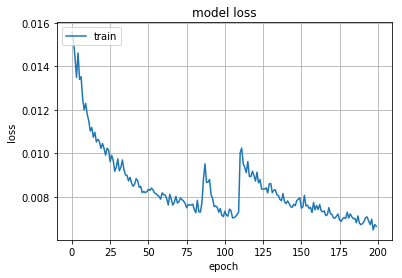

In [70]:
%matplotlib inline 
plt.plot(history.history['loss'])
#plt.plot(history.history['mean_squared_error'], label='Mean Squared Error')
plt.grid()
plt.legend(['train'], loc='upper left')
plt.title('model loss')
plt.xlabel("epoch")
plt.ylabel("loss")
plt.show()

In [71]:
def getResults():
    X_test = pd.read_csv("X_test_codes.csv", index_col=0)
    X_test_big = np.array(X_test.copy(), dtype=float)
    X_test_big = np.append(X_test_big, X_test_big, axis=0)
    X_test_big = np.append(X_test_big, X_test_big, axis=0)
    
    bots = np.zeros((800, 4), dtype=np.int)
    bots[0:200, 0] = 1
    bots[200:400, 1] = 1
    bots[400:600, 2] = 1
    bots[600:800, 3] = 1
    
    X_test_big = np.append(X_test_big, bots, axis=1)
    X_test_big = np.expand_dims(X_test_big, axis=2)
    
    print(X_test_big.shape)
    
    y_test_big = model.predict_proba(X_test_big)
    
    print(y_test_big.shape)
    
    bots_list = ['A1'] * 200 + ['A2'] * 200 + ['B1'] * 200 + ['B2'] * 200
    output = pd.DataFrame(bots_list, columns=['bot'])
    output['deck'] = list(X_test.index) * 4
    output['prob'] = y_test_big     # For two classes [:, 0]
    
    def f(x):
        return x * 100
    
    output['prob'] = output['prob'].apply(f)
    #output['prob'] = output['prob'].apply(lambda x: round(x, 2))
    print(output)
    
    output.to_csv('results.csv', sep=';', header=False, index=False)

In [72]:
getResults()

(800, 43, 1)
(800, 1)
    bot        deck       prob
0    A1  deck244804  41.574746
1    A1  deck124802  44.687140
2    A1  deck687350  48.087934
3    A1  deck517728  47.169596
4    A1  deck130762  37.680089
5    A1  deck322071  43.254325
6    A1  deck874296  62.518579
7    A1  deck206745  59.527737
8    A1  deck895482  65.049863
9    A1  deck160842  65.664589
10   A1  deck838916  37.914836
11   A1  deck780914  40.215561
12   A1  deck750047  37.618837
13   A1  deck652829  48.784000
14   A1  deck804465  45.497751
15   A1  deck527231  41.210532
16   A1  deck564938  52.034611
17   A1  deck960955  44.455731
18   A1  deck573326  50.985819
19   A1  deck197957  42.043900
20   A1  deck592549  43.873373
21   A1  deck590796  60.920173
22   A1  deck454901  61.560470
23   A1  deck224429  63.984865
24   A1  deck237007  44.440347
25   A1  deck679633  53.228557
26   A1  deck333404  51.397884
27   A1  deck865510  41.540051
28   A1  deck445345  45.138392
29   A1  deck331249  65.982836
..   ..         .